# Maximum Entropy Matching Distribution Function

This notebook can construct the distribution function which maximizes the kinetic entropy subject to the constraints of matching the energy density $\epsilon$ and the total isotropic pressure $P \equiv p + \Pi$.

The entropy density current is expressed

$$s^{\mu}(x) = - \sum_h \frac{g_h}{(2\pi)^3}\int \frac{d^3p}{p_0} p^{\mu} \phi[f_h],$$

where $h$ runs over all hadronic species, $g_h$ is the degeneracy of species $h$, and $f_h(x;p)$ is the distribution function of particles of species $h$.

The function $\phi[f_h]$ defined by

$$ \phi[f] \equiv f \ln (f) - \frac{1 + \theta f}{\theta} \ln(1 + \theta f)$$

defines the quantum statistical nature of the particles, with $\theta = 1$, $0$ or $-1$ for bosons, Maxwell-Boltzmann particles, and fermions respectively.

In [1]:
#%load_ext Cython
from scipy import integrate
from scipy import interpolate
from scipy.interpolate import RectBivariateSpline
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dill
import pandas as pd
sns.set()
sns.set_context('talk')

In [2]:
### physical constants
hbarc = 0.197 # GeV * fm

## The cell below constructs the grid of energy density and pressure
It takes a while to run. Unless we need to change the particle/grid options, we can just load the grid from disk.
If you want to change the grid limits, discretization, or change the Hadron Resonances Gas, it needs to be rerun.
To do this, set `recalculate_grids = True`.

The particle information is loaded from the PDG particle data table using functions defined here: https://github.com/Duke-QCD/frzout.

In [3]:
#%%cython 
import numpy as np
#cimport numpy as np
from scipy import integrate
import time
#from libc.math cimport exp
#from libc.math cimport sqrt
from numpy import exp
from numpy import sqrt


#DTYPE = np.float
#ctypedef np.float_t DTYPE_t

from species import species_dict, _normalize_species, urqmd
species = _normalize_species(species=urqmd)
for pid in species:
    pid[1]['sign'] = 1. if pid[1]['boson'] else -1.
n_species = len(species)

############################
########USER OPTIONS########
#particles included in thermodynamic quantities
chosen_particles = species_dict.keys()

#Grid parameters
npts_beta = 100 #size of grid in beta 
npts_rho = 150 #size of grid in rho 

T_eff_max = 0.20 #GeV
T_eff_min = 0.05 #GeV

#|lambda| <= |beta|
#so define rho by lambda = rho * beta, with rho in [-1, 1]
rho_min = -0.8
rho_max = 0.8
############################
########USER OPTIONS########

beta_min = 1. / T_eff_max #GeV^-1
beta_max = 1. / T_eff_min #GeV^-1
beta_grid = np.linspace(beta_min, beta_max, npts_beta)

rho_grid = np.linspace(rho_min, rho_max, npts_rho)

# The Max. Entropy Distribution Function
def f_dist(E, beta, rho, m, sign):
    E2 = E*E
    m2 = m*m
    lambdapi = rho*beta
    arg = E * ( beta + lambdapi*(1. - m2/E2) )
    return 1./(exp(arg) - sign)

# The Equil. Distribution Function
def f_eq(E, beta_eq, sign):
    arg = beta_eq * E
    return 1./(exp(arg) - sign)

# The Linear CE RTA distribution
def f_CE_lin(E, beta_eq, bulk_Pi, 
                     beta_Pi, F, m, sign, degen):
    E2 = E*E
    m2 = m*m
    f0 = f_eq(E, beta_eq, sign)
    f_fbar = f0 * (1. + sign*f0/degen)
    a = beta_eq * beta_eq * F * E
    b = beta_eq * (E2 - m2) / 3. / E
    df = f_fbar * bulk_Pi * (a + b) / beta_Pi
    f = f0 + df
    return f


### Load the pre-calculated grids from disk

In [4]:
#load the pre-calculated grid
eps_grid = np.loadtxt("grids/eps.dat")
P_grid = np.loadtxt("grids/P.dat")

eq_eps_grid = np.loadtxt("grids/eq_eps.dat")
eq_p_grid = np.loadtxt("grids/eq_p.dat")

In [5]:
#load the tables from iS3D for Linear Chapman Enskog
beta_Pi_df = pd.read_csv('grids/iS3D_tables/urqmd/betabulk.dat', sep='  ')
F_df = pd.read_csv('grids/iS3D_tables/urqmd/F.dat', sep='  ')

/Users/derek/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/Users/derek/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
beta_Pi_df['beta_Pi[fm^-4]'] = beta_Pi_df['betabulk_over_T4[fm^-4/GeV^4]'] * (beta_Pi_df['T[GeV]']**4. )
beta_Pi_df['beta[GeV^-1]'] = 1. / beta_Pi_df['T[GeV]']

F_df['F[fm^-1]'] = F_df['F_over_T[fm^-1/GeV]'] * F_df['T[GeV]']
F_df['beta[GeV^-1]'] = 1. / F_df['T[GeV]']


#ARE THESE THE RIGHT UNITS? CHECK...
F_df['F[GeV]'] = F_df['F[fm^-1]'] * hbarc
beta_Pi_df['beta_Pi[GeV/fm^3]'] = beta_Pi_df['beta_Pi[fm^-4]'] * hbarc

In [7]:
beta_Pi_df

,T[GeV],muB[GeV],betabulk_over_T4[fm^-4/GeV^4],beta_Pi[fm^-4],beta[GeV^-1],beta_Pi[GeV/fm^3]
0,0.100,0.0,9.173387,0.000917,10.000000,0.000181
1,0.101,0.0,9.458146,0.000984,9.900990,0.000194
2,0.102,0.0,9.747904,0.001055,9.803922,0.000208
3,0.103,0.0,10.042641,0.001130,9.708738,0.000223
4,0.104,0.0,10.342339,0.001210,9.615385,0.000238
...,...,...,...,...,...,...
96,0.196,0.0,67.448347,0.099540,5.102041,0.019609
97,0.197,0.0,68.526827,0.103211,5.076142,0.020333
98,0.198,0.0,69.617382,0.106999,5.050505,0.021079
99,0.199,0.0,70.720025,0.110906,5.025126,0.021848


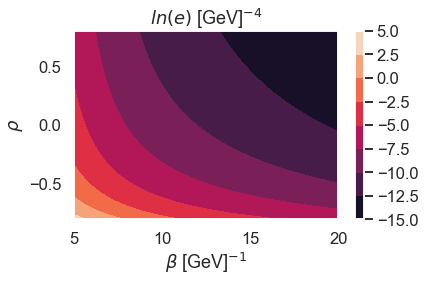

In [8]:
xx, yy = np.meshgrid(beta_grid, rho_grid)
plt.contourf(xx, yy, np.log(eps_grid.T) )
plt.xlabel(r"$\beta$ [GeV]$^{-1}$")
plt.ylabel(r"$\rho$")
plt.title(r"$ln(e)$ [GeV]$^{-4}$")
plt.colorbar()
plt.tight_layout(True)
plt.show()

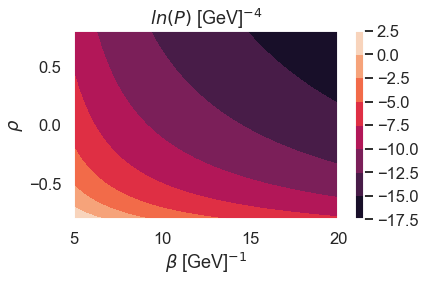

In [9]:
xx, yy = np.meshgrid(beta_grid, rho_grid)
#fig, axes = plt.subplots(1, 1, figsize=(6,4))
plt.contourf(xx, yy, np.log(P_grid.T) )
plt.xlabel(r"$\beta$ [GeV]$^{-1}$")
plt.ylabel(r"$\rho$")
plt.title(r"$ln(P)$ [GeV]$^{-4}$")
plt.colorbar()
plt.tight_layout(True)
plt.show()

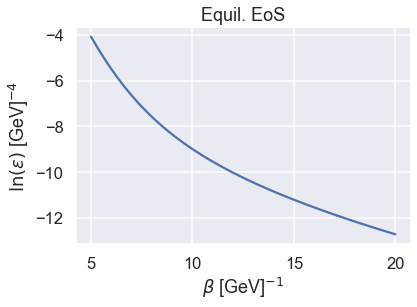

In [10]:
plt.plot(beta_grid, np.log(eq_eps_grid) )
plt.xlabel(r'$\beta$ [GeV]$^{-1}$')
plt.ylabel(r'$\ln(\epsilon)$ [GeV]$^{-4}$')
plt.title(r'Equil. EoS')
plt.show()

### Now we will create interpolations of the grid. 
This will allow us to invert the relations
$$\epsilon = \epsilon(\beta, \rho)$$
$$P = P(\beta, \rho)$$

into 

$$\beta = \beta(\epsilon, P)$$
$$\rho = \rho(\epsilon, P).$$

Once we have the interpolations $\epsilon = \epsilon(\beta, \rho)$ and $P = P(\beta, \rho)$, these can be inverted simultaneously by a two-dimensional root-finding routine.
The Andersen method in the `SciPy` implementation has done fairly well for our tests.

In a real phenomenological setting, each cell on the particlization surface may have a different isotropic pressure, and perhaps a different energy density. In this case, the interpolations can be loaded and reused together with the root finding method to find the Lagrange multipliers $\beta$ and $\rho$ for each cell.

In [11]:
#creating interpolations of the energy density e(beta, lambda) 
#and total pressure P(beta, lambda)
ln_eps_interp = RectBivariateSpline(beta_grid, rho_grid, np.log(eps_grid) )
ln_P_interp = RectBivariateSpline(beta_grid, rho_grid, np.log(P_grid) )

ln_eq_eps_interp = interpolate.interp1d(np.log(eq_eps_grid), beta_grid )
ln_eq_eps_given_beta_interp = interpolate.interp1d(beta_grid, np.log(eq_eps_grid) )

ln_eq_p_interp = interpolate.interp1d(beta_grid, np.log(eq_p_grid) )
#ln_eq_beta_Pi_interp = interpolate.interp1d(beta_grid, np.log(eq_beta_Pi_grid) )

#careful beta_Pi < 0
ln_beta_Pi_interp = interpolate.interp1d(beta_Pi_df['beta[GeV^-1]'], np.log(beta_Pi_df['beta_Pi[GeV/fm^3]']) )
F_interp = interpolate.interp1d(F_df['beta[GeV^-1]'],  F_df['F[GeV]'] )

### Testing the root-finding method and plotting the distribution

In [12]:
##FOR TESTING ROOT SOLVING
#true values of beta and rho
#beta_true = 6.
#rho_true = 0.5
#the values of energy density and total pressure are given
#ln_e0 = ln_eps_interp(beta_true, rho_true).flatten()[0] 
#ln_P0 = ln_P_interp(beta_true, rho_true).flatten()[0] 
##FOR TESTING ROOT SOLVING

##FOR PLOTTING 
T_sw = 0.15 #typical switching temperature in GeV
beta_sw = 1./ T_sw

ln_e0 = ln_eq_eps_given_beta_interp(beta_sw) 

p_sw = np.exp( ln_eq_p_interp(beta_sw) )
bulk_Pi_sw = -1.* p_sw / 2
#bulk_Pi_sw = 0. # to test if all three agree for Pi = 0
P0_sw = p_sw + bulk_Pi_sw
ln_P0 = np.log(P0_sw)
##FOR PLOTTING 


beta_Pi0 = np.exp(ln_beta_Pi_interp(beta_sw))
F0 = F_interp(beta_sw)

print("ln_e0 = " + str(ln_e0) + ", ln_P0 = " + str(ln_P0))

def my_fun(x):
    """input is vector with x[0] = beta, x[1] = rho"""
    ln_eps_func = ln_eps_interp(x[0], x[1]).flatten()[0] 
    ln_P_func = ln_P_interp(x[0], x[1]).flatten()[0] 
    return [ln_eps_func - ln_e0, ln_P_func - ln_P0]

ln_e0 = -6.2853249659612676, ln_P0 = -8.731406443593077


In [13]:
#the initial guess
guess = [7.0, 0.0] #[beta, rho]

method='anderson'
tol=1e-7
maxiter = int(1e5)

solution = optimize.root(my_fun, guess, method=method, tol=tol, options={'maxiter':maxiter})
solution

     fun: array([-2.11910489e-11, -1.33903377e-09])
 message: 'A solution was found at the specified tolerance.'
     nit: 18
  status: 1
 success: True
       x: array([5.39602141, 0.71267794])

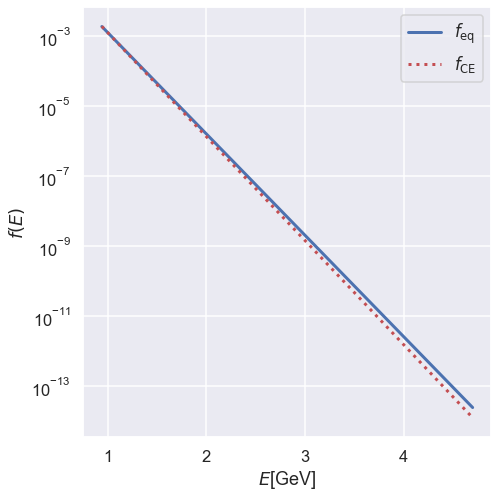

In [14]:
#now plot these functions

#m = 0.135 #pion
m = 0.94 #proton
sign  = -1.
degen = 1. #fix this!!!!

fig, axes = plt.subplots(1, 1, figsize=(7,7))
beta_soln = solution.x[0]
rho_soln = solution.x[1]
 
E_grid = np.linspace(m, 5.*m, 500)

f_ME_vals = [f_dist(E, beta_soln, rho_soln, m, sign) for E in E_grid]
f_eq_vals = [f_eq(E, beta_sw, sign) for E in E_grid]
f_lin_CE_vals = [f_CE_lin(E, beta_sw, bulk_Pi_sw, beta_Pi0, F0, m, sign, degen) \
                 for E in E_grid] 
plt.semilogy()
plt.plot(E_grid, f_eq_vals, lw=3, label=r'$f_{\rm eq}$', ls='-', color='b')
plt.plot(E_grid, f_lin_CE_vals, lw=3, label=r'$f_{\rm CE}$', ls=':', color='r')

#ratio = np.array(f_lin_CE_vals) / np.array(f_eq_vals)
#plt.plot(E_grid, ratio, lw=3, label=r'$f_{\rm CE} / f_{\rm eq}$', ls=':', color='r')

plt.xlabel(r'$E$[GeV]')
plt.ylabel(r'$f(E)$')
plt.legend()
plt.tight_layout(True)
plt.savefig('proton_dist.png', dpi=400)
plt.show()